# **Part 1: Setting up `Cart-Pole` Agent.**

- `Name` : **Pavaris Asawakijtananont**
- `Number` : 65340500037

## **1. RL Base class**

### **Constructor** 

### **Core Function**

From the Cart-Pole environment configuration file, we found that the observation space of the Cart-Pole consists of four components:

1. Relative joint velocity of the cart.
2. Relative joint velocity of the pole.
3. Relative joint position of the cart.
4. Relative joint position of the pole.

Each component is continuous and has an $\infty$ range, which results in high computational costs and an excessively large number of states. To discretize the observation state, we must first determine the complete range of values in the environment. Some of these parameters can be obtained from the Cart-Pole configuration file.

```python
CARTPOLE_CFG = ArticulationCfg(
    spawn=sim_utils.UsdFileCfg(
        usd_path=f"{ISAACLAB_NUCLEUS_DIR}/Robots/Classic/Cartpole/cartpole.usd",
        rigid_props=sim_utils.RigidBodyPropertiesCfg(
            rigid_body_enabled=True,
            max_linear_velocity=1000.0,
            max_angular_velocity=1000.0,
            max_depenetration_velocity=100.0,
            enable_gyroscopic_forces=True,
        ),
        articulation_props=sim_utils.ArticulationRootPropertiesCfg(
            enabled_self_collisions=False,
            solver_position_iteration_count=4,
            solver_velocity_iteration_count=0,
            sleep_threshold=0.005,
            stabilization_threshold=0.001,
        ),
    ),
    init_state=ArticulationCfg.InitialStateCfg(
        pos=(0.0, 0.0, 2.0), joint_pos={"slider_to_cart": 0.0, "cart_to_pole": 0.0}
    ),
    actuators={
        "cart_actuator": ImplicitActuatorCfg(
            joint_names_expr=["slider_to_cart"],
            effort_limit=400.0,
            velocity_limit=100.0,
            stiffness=0.0,
            damping=10.0,
        ),
        "pole_actuator": ImplicitActuatorCfg(
            joint_names_expr=["cart_to_pole"], effort_limit=400.0, velocity_limit=100.0, stiffness=0.0, damping=0.0
        ),
    },
)
```

1. `pose_cart` : cart position we can set up on termination condition and we must have tolerance before terminate **[ -$\pi$ , $\pi$ ]** 
2. `pose_pol` : Isaac Sim have angle between **[ -$\pi$ , $\pi$ ]**
3. `vel_cart` : velocity of cart is determine by `velocity_limit` of joint `slider_to_cart` is **[-100 , 100]**
4. `vel_pol` : actuator set in **100 rad/s** 

all parameter must fine-tuning after training because sometime too much range will hard to discretize and too much state

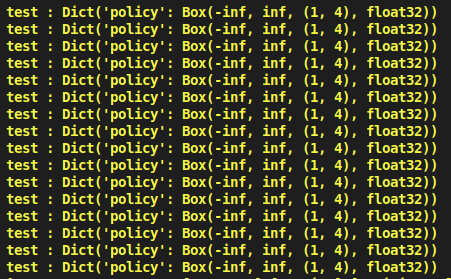

test , observation term start from 1 term , etc

#### **discretize_state(self , obs)**

- Discretizes and scales the state based on observation weights.
- to approximate state from continuos domain to discrete domain to estimate the state

```python

    def discretize_state(self, obs: dict):
        
        # define number of value
        pose_cart_bin = self.discretize_state_weight[0]
        pose_pole_bin = self.discretize_state_weight[1]
        vel_cart_bin = self.discretize_state_weight[2]
        vel_pole_bin = self.discretize_state_weight[3]

        # Clipping value
        pose_cart_bound = 4.5
        pose_pole_bound = np.pi
        vel_cart_bound = 10
        vel_pole_bound = 10
        
        # get observation term from continuos space
        pose_cart_raw, pose_pole_raw , vel_cart_raw , vel_pole_raw = obs['policy'][0, 0] , obs['policy'][0, 1] , obs['policy'][0, 2] , obs['policy'][0, 3]

        pose_cart_clip = torch.clip(pose_cart_raw , -pose_cart_bound ,pose_cart_bound)
        pose_pole_clip = torch.clip(pose_pole_raw , -pose_pole_bound ,pose_pole_bound)
        vel_cart_clip = torch.clip(vel_cart_raw , -vel_cart_bound ,vel_cart_bound)
        vel_pole_clip = torch.clip(vel_pole_raw , -vel_pole_bound ,vel_pole_bound)

        device = pose_cart_clip.device

        # linspace value
        pose_cart_grid = torch.linspace(-pose_cart_bound , pose_cart_bound , pose_cart_bin , device=device)
        pose_pole_grid = torch.linspace(-pose_pole_bound , pose_pole_bound , pose_pole_bin , device=device)
        vel_cart_grid = torch.linspace(-vel_cart_bound , vel_cart_bound , vel_cart_bin , device=device)
        vel_pole_grid = torch.linspace(-vel_pole_bound , vel_pole_bound , vel_pole_bin , device=device)

        # digitalize to range
        pose_cart_dig = torch.bucketize(pose_cart_clip,pose_cart_grid)
        pose_pole_dig = torch.bucketize(pose_pole_clip,pose_pole_grid)
        vel_cart_dig = torch.bucketize(vel_cart_clip,vel_cart_grid)
        vel_pose_dig = torch.bucketize(vel_pole_clip,vel_pole_grid)

        return ( int(pose_cart_dig), int(pose_pole_dig), int(vel_cart_dig),  int(vel_pose_dig))

```

1. Define the number of bins for each variable in discrete space:
    - The observation consists of four continuous variables:
        - pose_cart (cart position)
        - pose_pole (pole angle)
        - vel_cart (cart velocity)
        - vel_pole (pole angular velocity)
    - The number of bins for each variable is determined by `self.discretize_state_weight`, which contains the bin count for each variable.

2. Define maximum boundary values for clipping:
    - To prevent extreme values from distorting the discretization process, we clip each variable to a fixed range:

3. Clip the continuous values to the defined boundaries:
    - The function extracts continuous values from `obs['policy']` and ensures they stay within the predefined range using `torch.clip()`. This prevents values from exceeding the expected range.

4. Create uniform grids for discretization:
    - Using `torch.linspace()`, the function generates evenly spaced grid points that divide the clipped continuous space into discrete bins. Each variable's range is divided into a specified number of bins.

5. Discretize (bucketize) the continuous values into uniform ranges:
    - `torch.bucketize()` assigns the clipped continuous values to their respective bins.
    This ensures each variable is mapped to an integer index starting from 0, making it suitable for discrete RL algorithms.
    Return the discrete state tuple:

6. The function returns a tuple, each representing a discretized version of the original continuous state.

#### **get_discretize_action(self, obs_dis)**

- Get the action index or action in the discrete domain from the policy by using the `Epsilon-Greedy`. This method selects an action either by exploring (choosing a random action with probability ε) or by exploiting (choosing the action with the highest reward with probability 1 - ε)

```python
    def get_discretize_action(self, obs_dis) -> int:
        rand = np.random.rand() # random with unitform distribution

        if(rand <= self.epsilon): # Exploration [Random action]
            return np.random.randint(0, self.num_of_action)
        elif (rand > self.epsilon): # Exploitation [Greedy action]
            return np.argmax(self.q_values[obs_dis]) 
```

- Get discrete state input to select the action
- random a value to compare with epsilon to selects policy
    - if **Exploration** or equal-less than epsilon : 
        - random action with random action policy
    - else if **Exploitation** : 
        - using learning policy to select action by find a current optimal value by searching maximum action value 

#### **mapping_action(self, action)**

- Maps a discrete action in range [0, n] to a continuous value in [action_min, action_max]

```python
    def mapping_action(self, action):
        """
        Maps a discrete action in range [0, n] to a continuous value in [action_min, action_max].

        Args:
            action (int): Discrete action in range [0, n]
            n (int): Number of discrete actions
        
        Returns:
            torch.Tensor: Scaled action tensor.
        """
        # ========= put your code here =========#
        return torch.tensor([[action * ((self.action_range[1] - self.action_range[0]) / (self.num_of_action-1 )) + self.action_range[0]]])
```

#### **decay_epsilon(self)**

- Decreases epsilon over time and returns the updated value.

```python
    def decay_epsilon(self):
        """
        Decay epsilon value to reduce exploration over time.
        """
        self.epsilon = max(self.final_epsilon ,self.epsilon-self.epsilon_decay)
```


---

## **2. Learning Algorithm**

### **Monte Carlo class**

- Monte Carlo is updating always update value after episode is ending
    - episode will end when **`env.step(action)`** return `terminate` or `truncate`

```python
    def update(self,obs_dis,action_idx,reward,done):
        self.obs_hist.append(obs_dis)
        self.action_hist.append(action_idx)
        self.reward_hist.append(reward)
        
        if done:
            G_cum = 0 # return
            for t in range(len(self.obs_hist) - 1, -1, -1): # Loop from the last state to the first state [T-1, T-2, ..., 0]
                G_cum = self.discount_factor * G_cum + self.reward_hist[t]
                if (self.obs_hist[t], self.action_hist[t]) not in list(zip(self.obs_hist[:t], self.action_hist[:t])):   # if First Visit
                    self.n_values[self.obs_hist[t]][self.action_hist[t]] += 1
                    self.q_values[self.obs_hist[t]][self.action_hist[t]] += (G_cum - self.q_values[self.obs_hist[t]][self.action_hist[t]]) / self.n_values[self.obs_hist[t]][self.action_hist[t]]
                    
            self.obs_hist.clear()
            self.action_hist.clear()
            self.reward_hist.clear()
```

- At the end of an episode, we need to reset the cumulative return to 0 and loop in reverse to compute the actual return from the agent's experience.
- When the agent visits a state for the first time in an episode, it must increment the state count and update the action value using the default action value update equation. However, there are special conditions for updating, such as not updating at every step.

$$
Q(S_t,A_t) = Q(S_t,A_t) +  \frac{G_t - q(S_t,A_t)}{N(S_t,A_t)}
$$


### **SARSA class**

- SARSA is updating policy every timestep to improve policy by using boostraping next state from experience

```python
    def update(self,obs_dis,action_idx,reward,next_obs_dis,done):
        if done: # not boostraping
            self.q_values[obs_dis][action_idx] += self.lr * (reward - self.q_values[obs_dis][action_idx])
        else:
            _next_action_idx = self.get_discretize_action(next_obs_dis)
            self.q_values[obs_dis][action_idx] += self.lr * (reward + self.discount_factor * self.q_values[next_obs_dis][_next_action_idx] - self.q_values[obs_dis][action_idx])
        pass

```

- if episode is not terminate will boostrapping and update q value with temperal differnce term

---

**First Run**
Q Learning
```python
    # hyperparameters
    num_of_action = 10
    action_range = [-5, 5]  # [min, max]
    discretize_state_weight = [10, 20, 10, 10]  # [pose_cart:int, pose_pole:int, vel_cart:int, vel_pole:int]
    learning_rate = 0.3
    n_episodes = 5000
    start_epsilon = 1.0
    epsilon_decay = 0.001  # reduce the exploration over time
    final_epsilon = 0.05
    discount = 1
```

- agent sometime tried to force cart to make pole to center but  often agent is do nothing
- when see in q value json file I can see most of state is not explore by agent


**Run 2**
```python
    # hyperparameters
    num_of_action = 4
    action_range = [-3, 3]  # [min, max]
    discretize_state_weight = [8, 12, 4, 4]  # [pose_cart:int, pose_pole:int, vel_cart:int, vel_pole:int]
    learning_rate = 0.3
    n_episodes = 3000
    start_epsilon = 1.0
    epsilon_decay = 0.001  # reduce the exploration over time
    final_epsilon = 0.05
    discount = 1
```


---


QL RUN 3 OVER SPACE